In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
data = pd.read_csv('D:/datasets/train.csv')

C:\Users\enith\AppData\Local\Temp\ipykernel_7492\2605412115.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data = np.array(data)
m, n = data.shape
print(n)
np.random.shuffle(data) 

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape
Y_train

785


array([0, 1, 9, ..., 0, 0, 5], dtype=int64)

In [3]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

In [4]:
def ReLU(Z):
    return np.maximum(Z, 0)

In [5]:
def softmax(Z):
    Z = Z.astype(np.float32)
    A = np.exp(Z) / np.sum(np.exp(Z), axis=0)
    A = A.astype(np.float32)
    return A

In [6]:
def forward_prop(W1, b1, W2, b2, X):
    n=8
    # Quantize weights 
    W1_q = quantize(W1, n)  
    W2_q = quantize(W2, n)
    
    # Forward pass
    Z1 = W1_q.dot(X) + b1
    A1 = ReLU(Z1)
    
    # Quantize activations
    A1_q = quantize(A1, n)   
    
    Z2 = W2_q.dot(A1_q) + b2
    A2 = softmax(Z2)
    
    return Z1, A1, Z2, A2

In [7]:
def ReLU_deriv(Z):
    return Z > 0

In [8]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [9]:
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    n=8
    one_hot_Y = one_hot(Y)
    
    # Calculate gradients
    dZ2 = A2 - one_hot_Y 
    dW2 = 1/m * dZ2.dot(A1.T)
    db2 = 1/m * np.sum(dZ2)
    
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1) 
    dW1 = 1/m * dZ1.dot(X.T)
    db1 = 1/m * np.sum(dZ1)

    # Quantize gradients 
    dW1_q = quantize(dW1, n)
    dW2_q = quantize(dW2, n)
    db1_q = quantize(db1, n)
    db2_q = quantize(db2, n)
    
    return dW1_q, db1_q, dW2_q, db2_q

In [10]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    n=8
    # Quantize gradients
    dW1_q = quantize(dW1, n)
    db1_q = quantize(db1, n)
    dW2_q = quantize(dW2, n)
    db2_q = quantize(db2, n)

    # Update weights  
    W1 = W1 - alpha * dW1_q 
    b1 = b1 - alpha * db1_q
    W2 = W2 - alpha * dW2_q
    b2 = b2 - alpha * db2_q
    
    return W1, b1, W2, b2

In [11]:
def get_predictions(A2):
    return np.argmax(A2, 0)

In [12]:
def get_accuracy(predictions, Y):
    #print(predictions, Y)
    return (np.sum(predictions == Y) / Y.size)*100

In [13]:
def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        with tf.device('/device:GPU:0'):
            Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
            dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
            W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
            loss = compute_loss(A2, Y)
            print("Loss: ", loss)
    return W1, b1, W2, b2

In [14]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

In [15]:
def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

In [16]:
def quantize(vals, n):
    scale = 2**n - 1
    q_vals = np.clip(vals * scale, -scale, scale)
    q_vals = np.fix(q_vals) / scale
    return q_vals

In [17]:
def compute_loss(A2, Y):
    one_hot_Y = one_hot(Y)
    loss = -np.sum(one_hot_Y * np.log(A2)) / Y.size
    return loss

In [18]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.01, 1500)

Iteration:  0
9.663414634146342
Loss:  2.613720788147391
Iteration:  10
9.74390243902439
Loss:  2.561272176690218
Iteration:  20
10.109756097560977
Loss:  2.5220325653204103
Iteration:  30
10.446341463414633
Loss:  2.4878172627367623
Iteration:  40
10.192682926829267
Loss:  2.458940270342478
Iteration:  50
10.55609756097561
Loss:  2.4340079919565016
Iteration:  60
10.946341463414635
Loss:  2.412782088680965
Iteration:  70
11.241463414634147
Loss:  2.3943504702434306
Iteration:  80
11.73170731707317
Loss:  2.3785454651524383
Iteration:  90
11.93170731707317
Loss:  2.3636218861603155
Iteration:  100
12.326829268292682
Loss:  2.3510374316035247
Iteration:  110
13.663414634146342
Loss:  2.339376520049281
Iteration:  120
14.69512195121951
Loss:  2.328841790350472
Iteration:  130
15.782926829268293
Loss:  2.3188742827118896
Iteration:  140
16.48048780487805
Loss:  2.310346922566251
Iteration:  150
17.1609756097561
Loss:  2.301530860110027
Iteration:  160
18.28292682926829
Loss:  2.2933866465

Prediction:  [0]
Label:  0


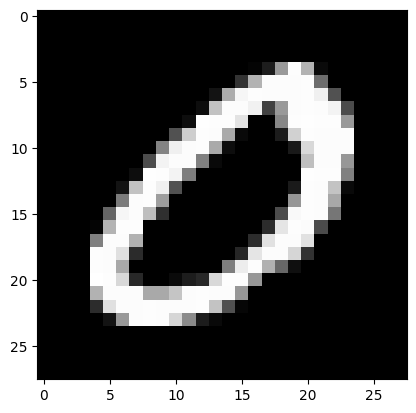

Prediction:  [1]
Label:  1


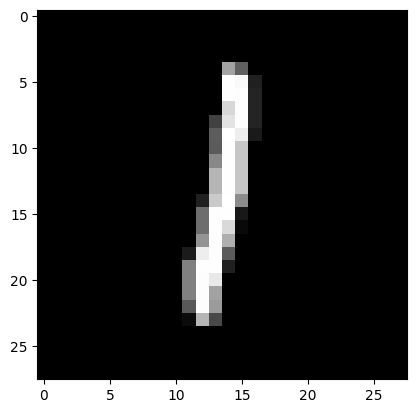

Prediction:  [9]
Label:  9


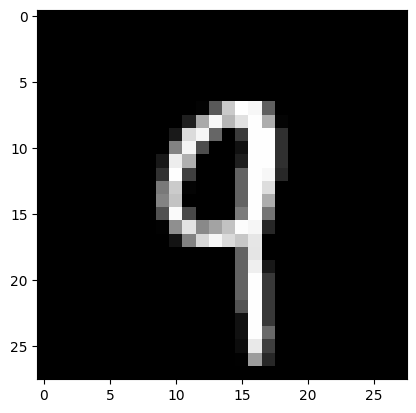

Prediction:  [3]
Label:  7


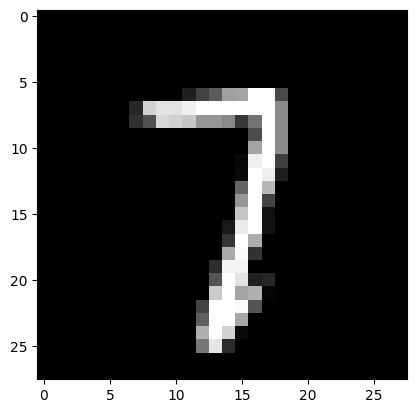

In [19]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

In [20]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)

In [21]:
print("Accuracy:",get_accuracy(dev_predictions, Y_dev))

Accuracy: 32.5
